In [1]:
from scipy import sparse
from als import ALS, ALSSparse
from dataset import MovieLensDataset
from argparse import ArgumentParser
import numpy as np
import json
import random
import os
import time
from utils import load_matrix, save_matrix
from datetime import datetime


def init_vector(shape, normalize=True):
    # np.random.seed(10)
    z = np.abs(np.random.randn(shape)).reshape(-1, 1).astype(np.float64)
    # u /= np.sum(u)
    return z / np.linalg.norm(z) if normalize else z


def average_stats(old_stats, new_run_stats, n):
    for k in new_run_stats:
        # store all runs list to compute mean/var
        if k == 'fun_evals' or k == 'grad_theta':
            if k not in old_stats:
                old_stats[k] = {str(n): new_run_stats[k]}
            else:
                old_stats[k][str(n)] = new_run_stats[k]
        elif k not in old_stats:
            old_stats[k] = new_run_stats[k]
        else:  # running average
            old_stats[k] = 1 / n * (new_run_stats[k] + (n - 1) * old_stats[k])
    return old_stats


def run_experiment(data,
                   sparse=True,
                   grad_sensibility=1e-8,
                   num_experiments=1,
                   warmup=0,
                   workers=8):
    date = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    X = data.X
    # print(trainX.shape, testX.shape)
    # optional warmup
    for _ in range(warmup):
        u = init_vector(data.n_users, normalize=True)
        v = init_vector(data.n_movies, normalize=True)
        args = [u, v, X]
        als = ALSSparse(*args) if sparse else ALS(*args)
        u, v = als.fit(eps_g=grad_sensibility)

    stats = {}
    start = time.time()
    for i in range(num_experiments):
        u = init_vector(data.n_users, normalize=True)
        v = init_vector(data.n_movies, normalize=True)
        args = [u, v, X]
        als = ALSSparse(*args) if sparse else ALS(*args)
        # run Alternating Least Squares algorithm
        u, v = als.fit(eps_g=grad_sensibility)
        # average results
        stats = average_stats(stats, als.stats, i + 1)
    end = time.time()
    # additional context info non depending from experiment results
    stats['number_of_ratings'] = X.getnnz(
    ) if sparse else np.count_nonzero(X)
    stats['dataset_path'] = data.path
    stats['grad_sensibility'] = grad_sensibility
    stats['theta_diff_sensibility'] = 1e-10
    stats['num_experiments'] = num_experiments
    stats['warmup_cycles'] = warmup
    stats['experiments_total_runtime'] = end - start
    stats['date'] = date
    stats['train_mse'] = als.function_eval() / stats['number_of_ratings']
    print("Train Mean Squared error is:", stats['train_mse'])

    # save results
    print("Saving results..")
    with open(f'../cm-results/datagrows/als_{"sparse" if sparse else "full"}_{date}.json',
              'w') as f:
        json.dump(stats, f, indent=4)

    return als


def show_movie_recommendations(d: MovieLensDataset):
    # sample k random movies already rated by user x in dataset
    movies_already_rated = random.sample(list(d.dataset()[userx].indices), k=5)
    # print(userx, movies_already_rated)
    # sample k random movies among all possible (use movie_counter since some movies might have multiple ratings)
    movie_list = random.sample(range(d.movie_counter), k=5)
    movie_ratings = {}
    # format result
    for m_id in movies_already_rated + movie_list:
        mdbid = d.get_movie_info(m_id)
        # get original (re-mapped) rating if present else compute it from factorization
        rating = d.dataset()[userx,
                             m_id] if m_id in movies_already_rated else float(
                                 als.u[userx] * als.v[m_id])
        movie_ratings[str(mdbid)] = {'title': mdbid, 'rating': f'{rating:.2f}'}
    print(json.dumps(movie_ratings, sort_keys=False, indent=4))


def evaluate(u: np.ndarray, v: np.ndarray, test_X, mode: str):
    print(u.shape, v.shape, test_X.shape, mode)
    a = ALSSparse(u, v, test_X) if mode == 'sparse' else ALS(
        u, v, test_X.toarray())
    mse = a.function_eval() / test_X.getnnz()
    print("Test set MSE:", mse)
    return mse

# Evaluate Performance as X size grows

In [2]:
for filename in ['xaa']:#['100k.csv', '1m.csv', '10m.csv']:
    dataset = MovieLensDataset(f'/home/nick/datasets/ml-25m/smaller/{filename}', mode='sparse', load_from_file=True)
    # run Alternating Least Squares algorithm
    als = run_experiment(dataset,
                         sparse=True,
                         grad_sensibility=1e-08,
                         num_experiments=1,
                         warmup=0,
                         workers=8)

Loading MovieLens dataset from /home/nick/datasets/ml-25m/smaller/xaa with mode sparse..
Column names are userId, movieId, rating, timestamp
Processed 10000000 lines. 64883 users x 46435 movies.
Dataset contains 9999999 ratings (0.3319124816864573% matrix density)

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[1]		31849348.531644963		141.38372765603694		1283201043.6317697

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[2]		29265357.548895475		22.77322690474288		40534605.58922007

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[3]		29210075.135475576		6.501810043712324		10870882.018634655

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[4]		29203540.573578216		2.798043305158716		4087370.310565017

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[5]		29202337.018739507		1.3638989989402677		1754484.7391697466

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	


# Plot data

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from glob import glob
data = {}
for fp in glob('/home/nick/uni/cm-results/datagrows/*.json'):
    with open(fp, 'r') as f:
        d = json.load(f)
        data[str(d['number_of_ratings'])] = d


In [2]:
data.keys()

dict_keys(['108371', '1039657', '9999999'])

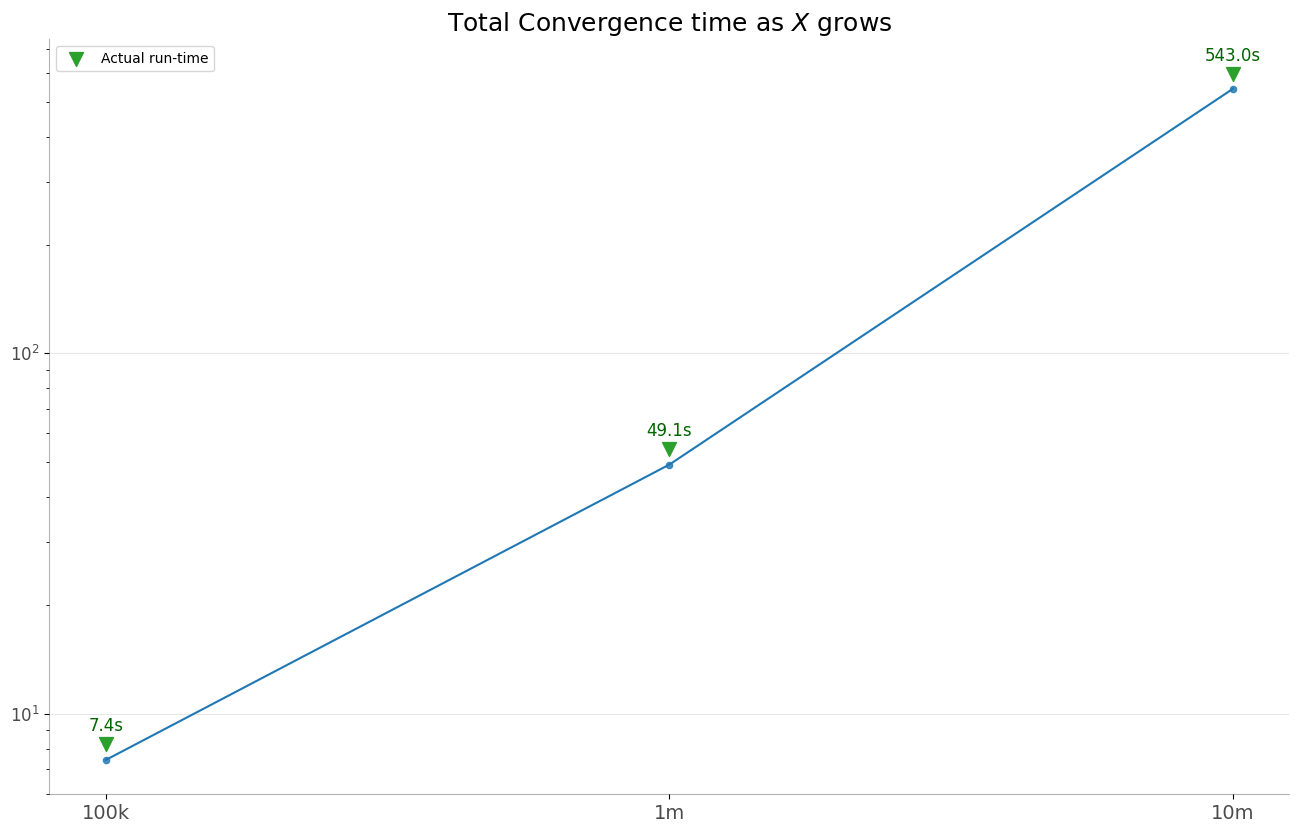

In [28]:
plt.figure(figsize=(16,10), dpi=100)
x = ['100k', '1m', '10m']
times = [v['total_convergence_time'] for k, v in data.items()]
itertimes = [v['avg_iter_time'] for k, v in data.items()]
plt.yscale('log')
plt.plot( np.array(times))
plt.scatter(np.arange(3), np.array(times), marker='o', s=20, alpha=0.8)
plt.scatter(np.arange(3), np.array(times)+np.array([.8, 5, 55]), marker='v', color='tab:green', s=100, label='Actual run-time')

offsets = np.array([1.5, 10, 105])
for xx in range(3):
    o = offsets[xx]
    plt.text(xx, times[xx]+o, f'{times[xx]:.1f}s', horizontalalignment='center', color='darkgreen', fontsize=12)
    
# Decoration
# plt.ylim(50,750)
# xtick_location = df.index.tolist()[::6]
# xtick_labels = df.date.tolist()[::6]
plt.xticks(ticks=[0,1,2], labels=x, fontsize=14, alpha=.7)
# plt.xticks([])
plt.title("Total Convergence time as $X$ grows", fontsize=18)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

In [38]:
itertimes

[0.23239246010780334, 1.3280860862216435, 11.313116798798243]

In [47]:
times

[7.436558723449707, 49.139185190200806, 543.0296063423157]